In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re

In [32]:
from instagrapi import Client

cl = Client()
cl.login(user_name, password)


Code entered "475042" for _karanjot_s (0 attempts by 5 seconds)


True

In [83]:
def scrap_insta(link):
    cl = Client()
    cl.login(user_name, password)
    media_id = cl.media_id(cl.media_pk_from_url(link))

    for i in cl.media_comments(media_id):
        record=[]
        record.append(i.text)
        record.append(i.like_count)
        raw_data.append(record)

In [84]:
raw_data=[]
scrap_insta("https://www.instagram.com/reel/Co2bQjLAxZc/")
raw_data

PleaseWaitFewMinutes: Please wait a few minutes before you try again.

## CREATING MODEL 

In [70]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import string
import pandas as pd


In [71]:
df=pd.DataFrame(raw_data)
df.columns=["COMMENTS","LIKES"]
df.sort_values("LIKES",ascending=False,inplace=True)
df

,COMMENTS,LIKES
1,Jai shree Ram,0.0
2,Jay shree ram 💖❣️🚩🚩🚩,0.0
3,Overacting kam karr,0.0
6,❤️,0.0
7,Jai Shree Ram 🚩🙏,0.0
8,😍😍😍😍,0.0
9,Jay shree ram ❤️,0.0
10,Amazing to hai hi 😍😍😍😍,0.0
13,Jay shree krishna krishna krishna 🙏😢🌹,0.0
14,Jai Shree Ram 🚩,0.0


# Cleaning Data


In [72]:
snowball_stemer = SnowballStemmer(language="english")
lzr = WordNetLemmatizer()
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/arnavgupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [73]:
def clean_comments(dataframe: pd.DataFrame):
    dataframe["cleaned"]=(
        dataframe["COMMENTS"]
        .str.strip()
        .str.replace("\n", " ")
        .str.replace(r"[^\w\s]+", "", regex=True)
        .str.lower()
        .str.replace(r"#\S+", " ", regex=True)
    )
    stop_words=stopwords.words('english')
    punctuations=list(string.punctuation)
    dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment: " ".join([word for word in comment.split() if word not in stop_words])) #removing stop words
    dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment: " ".join([word for word in comment.split() if word not in punctuation])) # removing punctuations

    dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment:" ".join([lzr.lemmatize(word) for word in comment.split()]))#Lemmatization

    #stemming(not recommended )
    #dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment :" ".join([snowball_stemer.stem(word) for word in comment.split()]))





    return dataframe



    


In [74]:
dfc=clean_comments(df)
dfc.head(10)

,COMMENTS,LIKES,cleaned
1,Jai shree Ram,0.0,jai shree ram
2,Jay shree ram 💖❣️🚩🚩🚩,0.0,jay shree ram
3,Overacting kam karr,0.0,overacting kam karr
6,❤️,0.0,
7,Jai Shree Ram 🚩🙏,0.0,jai shree ram
8,😍😍😍😍,0.0,
9,Jay shree ram ❤️,0.0,jay shree ram
10,Amazing to hai hi 😍😍😍😍,0.0,amazing hai hi
13,Jay shree krishna krishna krishna 🙏😢🌹,0.0,jay shree krishna krishna krishna
14,Jai Shree Ram 🚩,0.0,jai shree ram


In [75]:
def _get_polarity_score(analyzer: SentimentIntensityAnalyzer, text: str):

    scores = analyzer.polarity_scores(text)
    return scores["compound"]

def _convert_score_to_sentiment(score):
    sentiment = ""

    if score <0.0:
        sentiment = "Negative"
    elif -.05< score <= 0.5:
        sentiment = "Neutral"
    elif score >0.5:
        sentiment = "Positive"

    return sentiment

In [76]:
def test_1(dataframe : pd.DataFrame):
    analyzer=SentimentIntensityAnalyzer()
    dataframe["score"]=dataframe["cleaned"].apply(
        lambda comment : _get_polarity_score(analyzer,comment)
    )

    dataframe["sentiments"]=dataframe["score"].apply(
        lambda score: _convert_score_to_sentiment(score)
    )

    return dataframe

In [77]:
dff=test_1(dfc)
dff

,COMMENTS,LIKES,cleaned,score,sentiments
1,Jai shree Ram,0.0,jai shree ram,0.0000,Neutral
2,Jay shree ram 💖❣️🚩🚩🚩,0.0,jay shree ram,0.0000,Neutral
3,Overacting kam karr,0.0,overacting kam karr,0.0000,Neutral
6,❤️,0.0,,0.0000,Neutral
7,Jai Shree Ram 🚩🙏,0.0,jai shree ram,0.0000,Neutral
8,😍😍😍😍,0.0,,0.0000,Neutral
9,Jay shree ram ❤️,0.0,jay shree ram,0.0000,Neutral
10,Amazing to hai hi 😍😍😍😍,0.0,amazing hai hi,0.5859,Positive
13,Jay shree krishna krishna krishna 🙏😢🌹,0.0,jay shree krishna krishna krishna,0.0000,Neutral
14,Jai Shree Ram 🚩,0.0,jai shree ram,0.0000,Neutral


In [78]:
sentiment_counts_df = dff["sentiments"].value_counts().to_frame()
sentiment_counts_df.reset_index(inplace=True)
sentiment_counts_df.rename(columns={"index": "Sentiment", "sentiments": "Counts"}, inplace=True)
sentiment_counts_df = sentiment_counts_df.set_index("Sentiment")
sentiment_counts_df


,Counts
Sentiment,
Neutral,16
Negative,3
Positive,1


In [79]:
stats=dff["sentiments"].value_counts()
stats

Neutral     16
Negative     3
Positive     1
Name: sentiments, dtype: int64

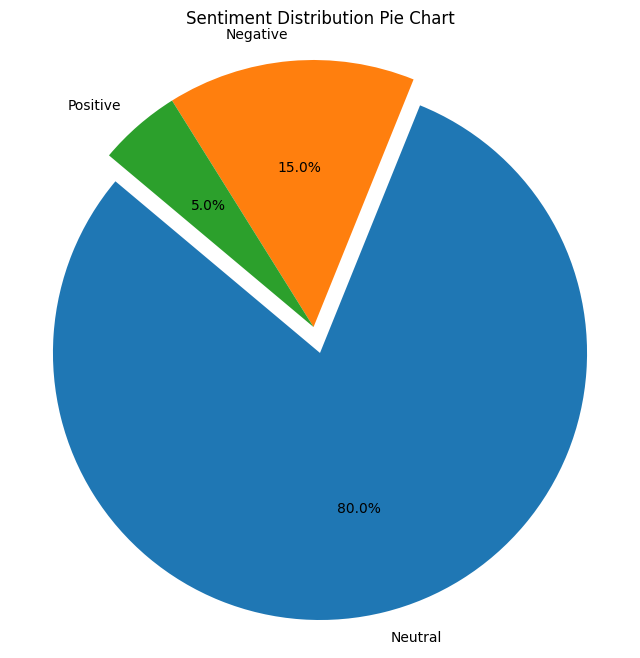

In [80]:
labels = sentiment_counts_df.index
counts = sentiment_counts_df["Counts"]

plt.figure(figsize=(8, 8)) 

max_index = counts.idxmax()
explode = [0.1 if sentiment == max_index else 0 for sentiment in labels]


plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)

plt.title('Sentiment Distribution Pie Chart')

plt.axis('equal')  
plt.show()
